In [8]:
# Cell 1: Import necessary libraries
import matplotlib.pyplot as plt  # Used for plotting and visualizing data.
import numpy as np  # Essential for numerical operations on arrays.
import cv2  # Provides tools for image processing.
from tqdm import trange  # Progress bar for loops.
from gymnasium.utils.env_checker import check_env  # Validates the configuration of gym environments.
from flygym import Fly, Camera  # Simulation classes for the Fly and its observational Camera.
from flygym.arena import FlatTerrain, OdorArena  # Environments for the simulation.
from flygym.examples.turning_controller import HybridTurningNMF  # Navigation model for the Fly.
from pathlib import Path  # Manipulates filesystem paths.

# Cell 2: Define parameters
Path("./outputs/outputs_finaux").mkdir(exist_ok=True)  # Ensure the output directory exists.

# Cell 4: Create the arena
peak_odor_intensity = np.array([[1, 0], [0, 0], [0, 0]])  # Peak intensity values for odor sources.
odor_source_A = np.array([[-2, 1, 0.2], [-5, -5, 0.2], [-1, 5, 0.2]])  # Coordinates for dynamic odor sources.

marker_colors = [[255, 127, 14]]  # Base color for visual markers (orange).
marker_colors_A = marker_colors + [[0, 0, 128], [0, 0, 128]]  # Additional marker colors (blue).
marker_colors = np.array([[*np.array(color) / 255, 1] for color in marker_colors])  # Convert to RGBA format.
marker_colors_A = np.array([[*np.array(color) / 255, 1] for color in marker_colors_A])  # Normalize and convert to RGBA.

flat_terrain_arena = FlatTerrain()
arena = OdorArena(
    odor_source=odor_source_A,
    peak_odor_intensity=peak_odor_intensity,
    diffuse_func=lambda x: x**-2,  # Function for how odor intensity decreases with distance.
    marker_colors=marker_colors_A,
    marker_size=0.3  # Visual marker size.
)

# Cell 5: Setup the fly and camera
contact_sensor_placements = [
    f"{leg}{segment}" for leg in ["LF", "LM", "LH", "RF", "RM", "RH"] for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]  # Sensor placements on the Fly's body.

# Positioning the fly facing horizontally to the left
fly = Fly(
    spawn_pos=(0, 1, 0.2),
    spawn_orientation=(0, 0, np.pi/2),  # Orientation facing left.
    contact_sensor_placements=contact_sensor_placements,
    enable_olfaction=True,  # Enable sensing of odors.
    enable_adhesion=True,  # Allows the Fly to adhere to surfaces.
    draw_adhesion=False  # Adhesion effects are not visually represented.
)

cam = Camera(
    fly=fly,
    camera_id="birdeye_cam",
    play_speed=0.2,  # Speed of the camera's playback.
    window_size=(1000, 608)  # Size of the camera's output window.
)

sim = HybridTurningNMF(
    fly=fly,
    cameras=[cam],
    arena=arena
)

# Simulation parameters
global white_area_bounds, attractive_gain, aversive_gain, decision_interval, run_time, num_decision_steps, physics_steps_per_decision_step, speed, curr_time, initial_xpos, n_delays
odor_dimensions = len(peak_odor_intensity[0])  # Number of dimensions in the odor intensity array.
white_area_bounds = [odor_source_A[1][:2], odor_source_A[2][:2]]  # Defined movement bounds for the odor sources.
attractive_gain = -500  # Gain for attraction to odors.
aversive_gain = 500  # Gain for aversion to odors.
decision_interval = 0.05  # Time interval between decisions in seconds.
run_time = 10  # Total simulation time in seconds.
num_decision_steps = int(run_time / decision_interval)  # Total number of decision steps.
physics_steps_per_decision_step = int(decision_interval / sim.timestep)  # Physics calculations per decision step.
speed = 5  # Speed factor for simulation.
curr_time = 0  # Current time initialization.
initial_xpos = odor_source_A[0][0]  # Initial X position.
n_delays = 10  # Number of time steps for delays.

# Cell 3: Define utility functions
def draw_white_area_corners(frame, bounds, color=(0, 0, 255), size=5):
    """ Draw corners on the image to define areas.
    Parameters:
        frame (ndarray): Image on which to draw.
        bounds (list of tuple): Coordinates defining the corners.
        color (tuple): Color for the corner marks.
        size (int): Radius of the corner marks.
    """
    x1, y1 = bounds[0]
    x2, y2 = bounds[1]
    corners = [(x1, y1), (x1, y2), (x2, y1), (x2, y2)]
    for corner in corners:
        pixel_x = int((corner[0] + 6.75) * 100)  # Adjusting scale for visualization.
        pixel_y = int((corner[1] - 0.46) * 100)
        cv2.circle(frame, (pixel_x, pixel_y), size, color, -1)
    return frame

def is_in_white_area(position, bounds):
    """ Check if a position is within defined bounds.
    Parameters:
        position (tuple): Coordinates to check.
        bounds (list of tuple): Boundary coordinates.
    """
    x, y = position[:2]
    x1, y1 = bounds[0]
    x2, y2 = bounds[1]
    return x1 <= x <= x2 and y1 <= y <= y2

# Marker binding for the odor sources in the simulation
marker = arena.root_element.find("body", "odor_source_marker_0")
sim.physics.bind(marker).mocap_pos[:2] = odor_source_A[0][:2]
arena.odor_source[0, :2] = odor_source_A[0][:2]

markerA = arena.root_element.find("body", "odor_source_marker_1")
sim.physics.bind(marker).mocap_pos[:2] = odor_source_A[1][:2]
arena.odor_source[0, :2] = odor_source_A[1][:2]

markerB = arena.root_element.find("body", "odor_source_marker_2")
sim.physics.bind(markerB).mocap_pos[:2] = odor_source_A[2][:2]
arena.odor_source[1, :2] = odor_source_A[2][:2]

# Cell 7: Run the simulation
def run_simulation(fly_mobile=True, source_mobile=False, bounds = False, white_area_bounds=white_area_bounds, bounds_speed = np.array([[0.03, 0.0], [0.03, 0.0]]), n_delays=n_delays):
    """ Execute the simulation under given conditions.
    Parameters:
        fly_mobile (bool): If true, the fly can move.
        source_mobile (bool): If true, the odor source can move.
        bounds (bool): If true, uses dynamic bounds.
        white_area_bounds (list): Initial boundaries for movement.
        bounds_speed (np.array): Speed at which bounds change.
        n_delays (int): Number of simulation delays.
    """
    global curr_time, initial_xpos, x_positions, times, obs_hist, odor_history, antennae_positions, O, HRC_model
    x_positions = []
    times = []
    obs_hist = []
    odor_history = []
    antennae_positions = []
    delayed_intensities = []
    obs, _ = sim.reset()

    for i in trange(num_decision_steps):
        antennae_pos = sim.physics.bind(fly._antennae_sensors).sensordata
        antennae_pos = antennae_pos.reshape(-1, 3)
        antennae_positions.append(antennae_pos)
        if bounds:
            white_area_bounds += bounds_speed
            odor_intensity = arena.get_olfaction(antennae_pos)
            for idx, sensor_pos in enumerate(antennae_pos):
                if not is_in_white_area(sensor_pos, white_area_bounds):
                    odor_intensity[:, idx] = 0
                    obs["odor_intensity"] = odor_intensity.astype(np.float32)
        attractive_intensities = np.average(obs["odor_intensity"][0, :].reshape(2, 2), axis=0, weights=[9, 1])
        aversive_intensities = np.average(obs["odor_intensity"][1, :].reshape(2, 2), axis=0, weights=[10, 0])

        control_signal = np.zeros((2,))
        delayed_intensities = O.pop(0)
        current_intensities = [obs["odor_intensity"][0, :][1], obs["odor_intensity"][0, :][3]]
        O.append(current_intensities)
        HRC_model.append(delayed_intensities[0] * current_intensities[1] - delayed_intensities[1] * current_intensities[0])

        odor_history.append(attractive_intensities + aversive_intensities)
        if source_mobile:
            xpos += 0.03
        if bounds:
            xposA += 0.03
            xposB += 0.03

        for j in range(physics_steps_per_decision_step):
            curr_time += sim.timestep
            times.append(curr_time)
            x_positions.append(xpos)

            if source_mobile:
                sim.physics.bind(marker).mocap_pos[:2] = [xpos, 1]
                arena.odor_source[0, :2] = [xpos, 1]
            if bounds:
                sim.physics.bind(markerA).mocap_pos[:2] = [xposA, -5]
                arena.odor_source[1, :2] = [xposA, -5]
                sim.physics.bind(markerB).mocap_pos[:2] = [xposB, 5]
                arena.odor_source[2, :2] = [xposB, 5]

            obs, _, _, _, _ = sim.step(control_signal)
            rendered_img = sim.render()[0]
            if rendered_img is not None:
                hrc_value = HRC_model[-1] if HRC_model else 0
                im = cv2.putText(
                    rendered_img,
                    f"HRC Model: {hrc_value:.8f}",
                    (100, 50),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1,
                    (0, 0, 0),
                    2,
                    cv2.LINE_AA,
                )
                cam._frames[-1] = im

            obs_hist.append(obs)



In [9]:

run_simulation(fly_mobile=False, source_mobile=False,bounds=True)

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [17:27<00:00,  5.24s/it]


In [10]:
x = list(range(num_decision_steps))
#divide x by 100
x = [((i+1)*48) / 200 for i in x]

In [11]:
cam.save_video("./outputs/outputs_finaux/exp_C_2_3.mp4")
#show graph HRC_model through time

[swscaler @ 0x7f7c9294a000] Warning: data is not aligned! This can lead to a speed loss


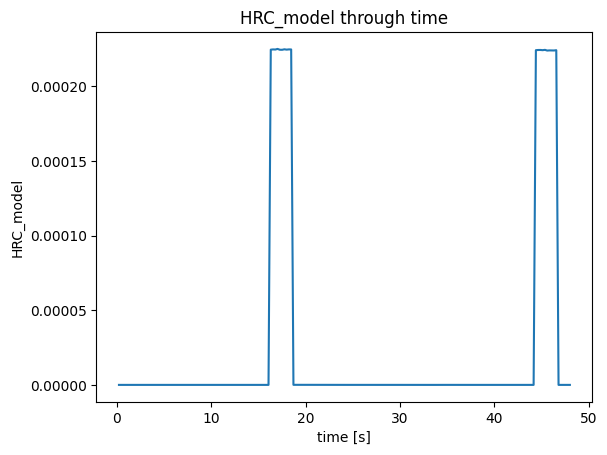

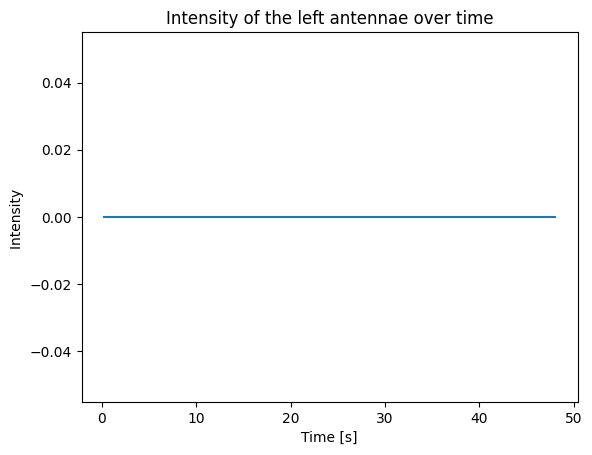

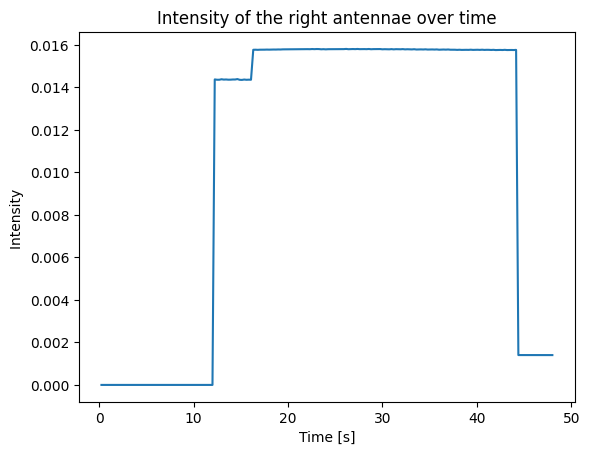

In [12]:

plt.plot(x,HRC_model)
 #change the values of the xlabel

plt.xlabel('time [s]')
plt.ylabel('HRC_model')
plt.title('HRC_model through time')
plt.savefig("./outputs/HRC_exp_C_2_3.png")
plt.show()

#HRC_model

# Extract the first column from odor_history
first_column = [entry[0] for entry in odor_history]

# Plot the first column
plt.plot(x,first_column)
plt.xlabel('Time [s]')
plt.ylabel('Intensity ')
plt.title('Intensity of the left antennae over time')
plt.savefig("./outputs/antenne_1_exp_C_2_3.png")
plt.show()

# Extract the second column from odor_history
second_column = [entry[1] for entry in odor_history]

# Plot the second column
plt.plot(x,second_column)
plt.xlabel('Time [s]')
plt.ylabel('Intensity ')
plt.title('Intensity of the right antennae over time')
plt.savefig("./outputs/antenne_2_exp_C_2_3.png")
plt.show()